In [1]:
import warnings
import json
from cProfile import label
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score,recall_score,precision_recall_curve,auc,precision_score,f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils import resample,shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from learn_curving_fold import plot_learning_curves
from imblearn.over_sampling import RandomOverSampler
import shap
import time
import copy
#from svm-gpu import SVM
from IPython.display import display
import os
import joblib
from tqdm import trange
from keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Conv1D, AveragePooling1D, BatchNormalization
from keras.layers.regularization.dropout import Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

d:\CODE\KD\kdenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def kfold_self_score_ensemble(
    cv = 5,
    scoring = ['misclassification error'],
    seperate = False,
    random_state=30,
    path = 'k_fold_train_validation_42',
    ):
    '''
    out_put -- the accuracy or other parameter in confusion matrix for the non upsampling validation set
    cv : inter, default:5 -- input how many fold we want to do
    model:default: None -- input the training model 
    point_amount: inter,default:20 -- set the train_size(input as how many point want to be seperate by max length of training data)
    sub_plot :boolean,default:False  -- True if want to plot the learning curve for each fold
    loss_log: boolean,default:False -- True if want to get the loss log for each fold,
                                        False for the average loss for 
                                        -train
                                        -nonupsampling validation
                                        -upsampling validation
    plot :boolean,default:True --True if want to plot the learning for after average
    scoring : lisg[str] (default: 'misclassification error')
        If not 'misclassification error', accepts the following metrics
        (from scikit-learn):
        {'accuracy', 'average_precision', 'f1_micro', 'f1_macro',
        'f1_weighted', 'f1_samples', 'log_loss',
        'precision', 'recall', 'roc_auc',
        'adjusted_rand_score', 'mean_absolute_error', 'mean_squared_error',
        'median_absolute_error', 'r2'}
    seperate:boolean, if we want to save the score for each fold 
    path: the folder for the datas
    '''
    specificity=[]
    f1 = []
    recall = []
    precision = []
    score = pd.DataFrame(columns=[])
    for i in range(1,cv+1):
        score['{}'.format(i)] = []
        specificity.append([])
        f1.append([])
        recall.append([])
        precision.append([])
    for type in scoring:
        print('start:',type)
        save = []  
        for i in trange(1,cv+1):
            xgboost = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/xgboost/{i}-model')
            adaboost = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/Adaboost/{i}-model')
            lgbm = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/lgbm/{i}-model')

            fold_test = pd.read_csv(path+'/{}-fold_test_z.csv'.format(i))
            ##rename(消去columns項內非英文以及數字的解)
            try:
                fold_test = fold_test.drop(columns=['Unnamed: 0'])
            except:
                pass
            fold_test = fold_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
            '=================================================================================='
            ## set the non upsampling validation for the single fold
            fold_test = shuffle(fold_test,random_state = random_state)
            fold_test= fold_test.reset_index(drop = True)
            x_test = fold_test.drop(columns=["Class"])
            y_test = fold_test['Class']

            ## get the tn,fp,fn,tp by confusion and therefore we can compute the specificity
            
            y_pred_xgboost = xgboost.predict_proba(x_test)[:,1]
            y_pred_adaboost = adaboost.predict_proba(x_test)[:,1]
            y_pred_lbgm = lgbm.predict_proba(x_test)[:,1]
            y_pred_average = (y_pred_adaboost+y_pred_lbgm+y_pred_xgboost)/3
            for count in range(len(y_pred_average)):
                if y_pred_average[count] >=0.5:
                    y_pred_average[count] = 1
                else:
                    y_pred_average[count] = 0
            
            ## log train/validationS loss for non upsampling
            ## tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            # specificity[i-1] = (tn / (tn+fp))
            if type == 'specificity':
                specificity[i-1] = recall_score(y_test, y_pred_average, pos_label=0)
            elif type == 'recall':   
                recall[i-1] = recall_score(y_test, y_pred_average, pos_label=1)
            elif type =='f1':
                f1[i-1] = f1_score(y_test, y_pred_average)
            elif type =='precision':
                precision[i-1] = precision_score(y_test, y_pred_average)
            del (fold_test)

        if type == 'specificity':
            for num in range(0,len(specificity)):
                save.append(specificity[num])
        elif type =='f1':
            for num in range(0,len(f1)):
                save.append(f1[num])
        elif type == 'recall':
            for num in range(0,len(recall)):
                save.append(recall[num])
        elif type =='precision':
            for num in range(0,len(precision)):
                save.append(precision[num])       

        score.loc['{}'.format(type)] = save
        print('finished:',type)
        
    score['average'] = score.sum(axis = 1)/cv
    if seperate == True:
        return(save)
    else:
        return(score)

In [30]:
def kfold_self_score_up_ensemble(
    cv = 5,
    scoring = ['misclassification error'],
    seperate = False,
    random_state=30,
    path = 'k_fold_train_validation_42',
    ):
    '''
    out_put -- the accuracy or other parameter in confusion matrix for the non upsampling validation set
    cv : inter, default:5 -- input how many fold we want to do
    model:default: None -- input the training model 
    point_amount: inter,default:20 -- set the train_size(input as how many point want to be seperate by max length of training data)
    sub_plot :boolean,default:False  -- True if want to plot the learning curve for each fold
    loss_log: boolean,default:False -- True if want to get the loss log for each fold,
                                        False for the average loss for 
                                        -train
                                        -nonupsampling validation
                                        -upsampling validation
    plot :boolean,default:True --True if want to plot the learning for after average
    scoring : lisg[str] (default: 'misclassification error')
        If not 'misclassification error', accepts the following metrics
        (from scikit-learn):
        {'accuracy', 'average_precision', 'f1_micro', 'f1_macro',
        'f1_weighted', 'f1_samples', 'log_loss',
        'precision', 'recall', 'roc_auc',
        'adjusted_rand_score', 'mean_absolute_error', 'mean_squared_error',
        'median_absolute_error', 'r2'}
    seperate:boolean, if we want to save the score for each fold 
    path: the folder for the datas
    '''
    specificity=[]
    f1 = []
    recall = []
    precision = []
    score = pd.DataFrame(columns=[])
    for i in range(1,cv+1):
        score['{}'.format(i)] = []
        specificity.append([])
        f1.append([])
        recall.append([])
        precision.append([])
    for type in scoring:
        print('start:',type)
        save = []  
        for i in trange(1,cv+1):
            xgboost = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/xgboost/{i}-model')
            adaboost = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/Adaboost/{i}-model')
            lgbm = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/lgbm/{i}-model')

            fold_test = pd.read_csv(path+'/{}-fold_test_z.csv'.format(i))
            ##rename(消去columns項內非英文以及數字的解)
            try:
                fold_test = fold_test.drop(columns=['Unnamed: 0'])
            except:
                pass
            fold_test = fold_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
            
            '=================================================================================='
            ## set the non upsampling validation for the single fold
            one_message_test = fold_test[fold_test["Class"] == 1 ]
            zero_message_test =fold_test[fold_test["Class"] == 0]
            one_message_up_test = resample(one_message_test,
                        replace=True,
                        n_samples=len(zero_message_test),
                        random_state=42)
            fold_test = pd.concat([one_message_up_test,zero_message_test])
            fold_test = shuffle(fold_test,random_state = random_state)
            fold_test= fold_test.reset_index(drop = True)         
            x_test = fold_test.drop(columns=["Class"])
            y_test = fold_test['Class']

            ## get the tn,fp,fn,tp by confusion and therefore we can compute the specificity
            
            y_pred_xgboost = xgboost.predict_proba(x_test)[:,1]
            y_pred_adaboost = adaboost.predict_proba(x_test)[:,1]
            y_pred_lbgm = lgbm.predict_proba(x_test)[:,1]
            y_pred_average = (y_pred_adaboost+y_pred_lbgm+y_pred_xgboost)/3
            for count in range(len(y_pred_average)):
                if y_pred_average[count] >=0.5:
                    y_pred_average[count] = 1
                else:
                    y_pred_average[count] = 0
            
            ## log train/validationS loss for non upsampling
            ## tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            # specificity[i-1] = (tn / (tn+fp))
            if type == 'specificity':
                specificity[i-1] = recall_score(y_test, y_pred_average, pos_label=0)
            elif type == 'recall':   
                recall[i-1] = recall_score(y_test, y_pred_average, pos_label=1)
            elif type =='f1':
                f1[i-1] = f1_score(y_test, y_pred_average)
            elif type =='precision':
                precision[i-1] = precision_score(y_test, y_pred_average)
            del (fold_test)

        if type == 'specificity':
            for num in range(0,len(specificity)):
                save.append(specificity[num])
        elif type =='f1':
            for num in range(0,len(f1)):
                save.append(f1[num])
        elif type == 'recall':
            for num in range(0,len(recall)):
                save.append(recall[num])
        elif type =='precision':
            for num in range(0,len(precision)):
                save.append(precision[num])       

        score.loc['{}'.format(type)] = save
        print('finished:',type)
        
    score['average'] = score.sum(axis = 1)/cv
    if seperate == True:
        return(save)
    else:
        return(score)

In [33]:
path = 'D:/CODE/KD/code_after_web/data/KeptGPT/without gender/k-fold/30' 
model_name = 'ensemble'
model_save_path = f'D:/CODE/KD/code_after_web/output/without gender/{model_name}'
if os.path.exists(model_save_path) == False:
    os.mkdir(model_save_path)

score = kfold_self_score_ensemble(path =path,scoring=['f1','precision','recall','specificity'],seperate = False,random_state=30)
score_up = kfold_self_score_up_ensemble(path =path,scoring=['f1','precision','recall','specificity'],seperate = False,random_state=30)
display(score)
display(score_up)


f1:5
start: f1


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


finished: f1
start: precision


100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


finished: precision
start: recall


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


finished: recall
start: specificity


100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


finished: specificity
f1:5
start: f1


100%|██████████| 5/5 [00:24<00:00,  4.83s/it]


finished: f1
start: precision


100%|██████████| 5/5 [00:24<00:00,  4.87s/it]


finished: precision
start: recall


100%|██████████| 5/5 [00:24<00:00,  4.81s/it]


finished: recall
start: specificity


100%|██████████| 5/5 [00:24<00:00,  4.80s/it]

finished: specificity


,1,2,3,4,5,average
f1,0.425750,0.402054,0.403079,0.406732,0.409913,0.409506
precision,0.279539,0.261450,0.259459,0.263876,0.267951,0.266455
recall,0.892638,0.869841,0.902821,0.886850,0.871795,0.884789
specificity,0.926203,0.923924,0.919166,0.920382,0.917530,0.921441


,1,2,3,4,5,average
f1,0.907717,0.893583,0.912966,0.901022,0.894352,0.901928
precision,0.923617,0.919509,0.918233,0.917474,0.913921,0.918551
recall,0.892355,0.869078,0.907759,0.885149,0.875604,0.885989
specificity,0.926203,0.923924,0.919166,0.920382,0.917530,0.921441


In [6]:
def plot_prc_curve(precision,recall,precision_up,recall_up,auc,auc_up,color_origin='orange',color_up='red'):
    # plot the PR region for origin distribution
    item_max = auc.index(max(auc))
    item_min = auc.index(min(auc))
    print('origin_best:',item_max+1,'origin_min:',item_min+1)
    #print(len(recall[item_max]))
    ## 修正接近x軸為零時，會有(0,0)產生
    recall_min = list(recall[item_min][0:(len(recall[item_min])-10)])
    precision_min = list(precision[item_min][0:(len(recall[item_min])-10)])
    recall_max = list(recall[item_max][0:(len(recall[item_max])-10)])
    precision_max = list(precision[item_max][0:(len(recall[item_max])-10)])
    #繪圖(sort&concatenate是為了內插而產生的X點)
    xfill = np.sort(np.concatenate([recall_max, recall_min]))
    y1fill = np.interp(xfill, recall_max[::-1],precision_max[::-1]) #因為x為 1 -> 0 而非0->1，所以需要再使用np.interp的時候要先顛倒x和y，使其由小到大才能做內插
    y2fill = np.interp(xfill,recall_min[::-1], precision_min[::-1])#因為x為 1 -> 0 而非0->1，所以需要再使用np.interp的時候要先顛倒x和y，使其由小到大才能做內插
    plt.plot(recall_max,precision_max,color = color_origin,linestyle='--',alpha=0.6)
    plt.plot(recall_min,precision_min,color = color_origin,linestyle='--',alpha=0.6)
    plt.plot(xfill,(y1fill+y2fill)/2,color = color_origin)
    plt.fill_between(xfill, y2fill, y1fill,interpolate=True, alpha=0.5, color=color_origin)


    #print(*precision[item_max])
    #plot the PR region for upsampling distribution
    item_up_max = auc_up.index(max(auc_up))
    item_up_min = auc_up.index(min(auc_up))
    print('up_best:',item_up_max+1,'up_min:',item_up_min+1)
    #修正接近x軸為零時，會有(0,0)產生
    recall_min_up = list(recall_up[item_up_min][0:(len(recall_up[item_up_min])-10)])
    precision_min_up = list(precision_up[item_up_min][0:(len(recall_up[item_up_min])-10)])
    recall_max_up = list(recall_up[item_up_max][0:(len(recall_up[item_up_max])-10)])
    precision_max_up = list(precision_up[item_up_max][0:(len(recall_up[item_up_max])-10)])
    #繪圖(sort&concatenate是為了內插而產生的X點)
    xfill_up = np.sort(np.concatenate([recall_max_up, recall_min_up]))
    y1fill_up = np.interp(xfill_up, recall_max_up[::-1],precision_max_up[::-1])
    y2fill_up = np.interp(xfill_up, recall_min_up[::-1], precision_min_up[::-1])
    plt.plot(recall_max_up,precision_max_up,color = color_up,linestyle='--',alpha=0.6)
    plt.plot(recall_min_up,precision_min_up,color = color_up,linestyle='--',alpha=0.6)
    plt.plot(xfill_up,(y1fill_up+y2fill_up)/2,color = color_up)
    plt.fill_between(xfill_up,y1fill_up, y2fill_up, interpolate=True, alpha=0.5, color=color_up)

    '''
    for i in range(len(precision)):
        plt.plot(precision[i],recall[i],color='red')#,label='PRC{},auc:'.format(i+1)+'%.3f'%(auc[i])) 
        plt.plot(precision_up[i],recall_up[i],color = 'orange',linestyle = '--')#,label = 'PRC_up{},auc:'.format(i+1)+'%.3f'%(auc_up[i]))
    '''
    plt.plot(1,1,color = color_origin,label='PRC,auc(avg):'+'%.3f'%(sum(auc)/len(auc)))
    plt.plot(1,1,color = color_up,linestyle = '--',label = 'PRC_up,auc(avg):'+'%.3f'%(sum(auc_up)/len(auc_up)))
    #plt.scatter(0.925,0.05)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.legend(loc='lower left')
    return(recall_min,precision_min,recall_max,precision_max,recall_min_up,precision_min_up,recall_max_up,precision_max_up,sum(auc)/len(auc),sum(auc_up)/len(auc_up))
def prc_plot_ensemble(
    fold = 5,
    path = 'k_fold_train_validation_42',
    color_origin='orange',
    color_up = 'orange',
    random_state_1 = 30,
    ):
    '''
    out_put : the roc plot for the single fold
    cv : inter, default:5 -- input how many fold we want to do
    model:default:None  -- input the training model 
    heat_map: boolean,default:False -- True if we want to output the heat map 
    random_state_1 : the random seed for the shuffle and oversampling for model1
    random_state_2: the random seed for the shuffle and oversampling for model2
    path: the folder for the datas that we train model 1
    path_2: the folder for the datas that we train model 2
    model_amount : inter, 1 or 2
    color_origin: only modifiy the prc color for second model(origin distribution)
    color_up: only modeifiy the prc color for second model(upsampling distribution)
    '''
    auc_list = []
    auc_list_up = []
    precision = []
    recall = []
    precision_up = []
    recall_up = []
    for i in trange(1,fold+1):
        #print('fold is :',i)
        '==============================upsampling train/origin model_1======================='
        fold_test = pd.read_csv(path+'/{}-fold_test_z.csv'.format(i))
        #rename(消去columns項內非英文以及數字的解)
        fold_test = fold_test.drop(columns=['Unnamed: 0'])
        fold_test = fold_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        #print(i,'-1')
        
        #print('x_train:',x_train,'y_train:',y_train)
        # set the non upsampling validation for the single fold
        fold_test = shuffle(fold_test,random_state = random_state_1)
        fold_test= fold_test.reset_index(drop = True)
        x_test = fold_test.drop(columns=["Class"])
        y_test = fold_test['Class']

        '=============================model training=============================================================='
        # get the tn,fp,fn,tp by confusion and therefore we can compute the specificity
        xgboost = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/xgboost/{i}-model')
        adaboost = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/Adaboost/{i}-model')
        lgbm = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/lgbm/{i}-model')
        
        y_pred_xgboost = xgboost.predict_proba(x_test)[:,1]
        y_pred_adaboost = adaboost.predict_proba(x_test)[:,1]
        y_pred_lbgm = lgbm.predict_proba(x_test)[:,1]
        y_pred_average = (y_pred_adaboost+y_pred_lbgm+y_pred_xgboost)/3

        #log train/validationS loss for non upsampling
        precision_i , recall_i , threshold = precision_recall_curve(y_test,y_pred_average, pos_label=1)
        precision.append(precision_i)
        recall.append(recall_i)
        '==================================upsampling train/upsampling test======================================='
        fold_test_up = pd.read_csv(path+'/{}-fold_test_z.csv'.format(fold))
        fold_test_up = fold_test_up.drop(columns=['Unnamed: 0'])
        fold_test_up = fold_test_up.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        one_message_test = fold_test_up[fold_test_up["Class"] == 1 ]
        zero_message_test =fold_test_up[fold_test_up["Class"] == 0]
        one_message_test_up = resample(one_message_test,
                replace=True,
                n_samples=len(zero_message_test),
                random_state=42)
        fold_test_up = pd.concat([one_message_test_up,zero_message_test])
        fold_test_up = shuffle(fold_test_up,random_state = 30)
        fold_test_up= fold_test_up.reset_index(drop = True)
        x_test_up = fold_test_up.drop(columns = ['Class'])
        y_test_up = fold_test_up["Class"]
        '=======================================auc==========================================================='
        y_pred_xgboost_up = xgboost.predict_proba(x_test_up)[:,1]
        y_pred_adaboost_up = adaboost.predict_proba(x_test_up)[:,1]
        y_pred_lbgm_up = lgbm.predict_proba(x_test_up)[:,1]
        y_pred_average_up = (y_pred_adaboost_up+y_pred_lbgm_up+y_pred_xgboost_up)/3
        
        
        precision_up_i,recall_up_i,threshold_up = precision_recall_curve(y_test_up,y_pred_average_up, pos_label=1)
        precision_up.append(precision_up_i)
        recall_up.append(recall_up_i)
        '=======================================auc==========================================================='
        auc_list.append(auc(recall[i-1],precision[i-1]))
        auc_list_up.append(auc(recall_up[i-1],precision_up[i-1]))
        del (fold_test)
    plt.figure(1)
    recall_min,precision_min,recall_max,precision_max,recall_min_up,precision_min_up,recall_max_up,precision_max_up,auc_avg,auc_up_avg = plot_prc_curve(precision,recall,precision_up,recall_up,auc_list,auc_list_up)

100%|██████████| 5/5 [00:36<00:00,  7.31s/it]

origin_best: 3 origin_min: 2
up_best: 3 up_min: 5


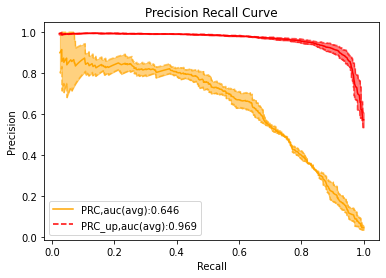

In [7]:
path = 'D:/CODE/KD/code_after_web/data/KeptGPT/without gender/k-fold/30' 
model_name = 'ensemble'
model_save_path = f'D:/CODE/KD/code_after_web/output/without gender/{model_name}'
if os.path.exists(model_save_path) == False:
    os.mkdir(model_save_path)
prc_curve_data = prc_plot_ensemble(path=path,random_state_1=30,color_origin='orange',color_up='red')

In [8]:
def plot_roc_curve(fper,tper,fper_up,tper_up,auc,auc_up,color_origin='orange',color_up='red'):
    '''
    for i in range(len(fper)):
        plt.plot(fper[i],tper[i],color='red')#,label='ROC,auc:'+'%.3f'%(sum(auc)/len(auc)))
        plt.plot(fper_up[i],tper_up[i],color = 'orange',linestyle = '--')#,label = 'ROC_up,auc:'+'%.3f'%(sum(auc_up)/len(auc_up)))
    '''
    ## plot the ROC region for orgin distribution 
    item_max = auc.index(max(auc))
    item_min = auc.index(min(auc))
    xfill = np.sort(np.concatenate([fper[item_max], fper[item_min]]))
    y1fill = np.interp(xfill, fper[item_max],tper[item_max])
    y2fill = np.interp(xfill, fper[item_min], tper[item_min])
    plt.plot(fper[item_max],tper[item_max],color = color_origin,linestyle='--', alpha=0.6)
    plt.plot(fper[item_min],tper[item_min],color = color_origin,linestyle='--',alpha=0.6)
    plt.plot(xfill,(y1fill+y2fill)/2,color = color_origin)
    plt.fill_between(xfill, y1fill, y2fill, interpolate=True, color=color_origin, alpha=0.5)
    ## plot the ROC region for upsampling distrubution
    item_up_max = auc_up.index(max(auc_up))
    item_up_min = auc_up.index(min(auc_up))
    xfill_up = np.sort(np.concatenate([fper_up[item_up_max], fper_up[item_up_min]]))
    y1fill_up = np.interp(xfill_up, fper_up[item_up_max],tper_up[item_up_max])
    y2fill_up = np.interp(xfill_up, fper_up[item_up_min], tper_up[item_up_min])
    plt.plot(fper_up[item_up_max],tper_up[item_up_max],color = color_up,linestyle='--',alpha=0.6)
    plt.plot(fper_up[item_up_min],tper_up[item_up_min],color = color_up,linestyle='--',alpha=0.6)
    plt.plot(xfill_up,(y1fill_up+y2fill_up)/2,color = color_up)
    plt.fill_between(xfill_up,y1fill_up,y2fill_up,interpolate=True,color =color_up,alpha = 0.15)

    plt.plot(1,1,color=color_origin,label='ROC,auc:'+'%.3f'%(sum(auc)/len(auc)))
    plt.plot(1,1,color = color_up,label = 'ROC_up,auc:'+'%.3f'%(sum(auc_up)/len(auc_up)))
    plt.plot([0,1],[0,1],color = 'green',linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.legend(loc='lower right')
    return(fper[item_max],tper[item_max],fper[item_min],tper[item_min],fper_up[item_up_max],tper_up[item_up_max],fper_up[item_up_min],tper_up[item_up_min],sum(auc)/len(auc),sum(auc_up)/len(auc_up))
def roc_plot_ensemble(
    fold = 5,
    path = 'k_fold_train_validation_42',
    color_origin='orange',
    color_up = 'orange',
    random_state_1 = 30,
    ):
    '''
    out_put : the roc plot for the single fold
    cv : inter, default:5 -- input how many fold we want to do
    model:default:None  -- input the training model 
    heat_map: boolean,default:False -- True if we want to output the heat map 
    random_state_1 : the random seed for the shuffle and oversampling for model1
    random_state_2: the random seed for the shuffle and oversampling for model2
    path: the folder for the datas that we train model 1
    path_2: the folder for the datas that we train model 2
    model_amount : inter, 1 or 2
    color_origin: only modifiy the prc color for second model(origin distribution)
    color_up: only modeifiy the prc color for second model(upsampling distribution)
    '''
    fper = []
    tper = []
    fper_up = []
    tper_up = []
    auc = []
    auc_up =[]
    for i in trange(1,fold+1):
        #print('fold is :',i)
        '==============================upsampling train/origin model_1======================='
        fold_test = pd.read_csv(path+'/{}-fold_test_z.csv'.format(i))
        #rename(消去columns項內非英文以及數字的解)
        fold_test = fold_test.drop(columns=['Unnamed: 0'])
        fold_test = fold_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        #print(i,'-1')
        
        #print('x_train:',x_train,'y_train:',y_train)
        # set the non upsampling validation for the single fold
        fold_test = shuffle(fold_test,random_state = random_state_1)
        fold_test= fold_test.reset_index(drop = True)
        x_test = fold_test.drop(columns=["Class"])
        y_test = fold_test['Class']

        '=============================model training=============================================================='
        # get the tn,fp,fn,tp by confusion and therefore we can compute the specificity
        xgboost = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/xgboost/{i}-model')
        adaboost = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/Adaboost/{i}-model')
        lgbm = joblib.load(f'D:/CODE/KD/code_after_web/output/without gender/lgbm/{i}-model')
        
        y_pred_xgboost = xgboost.predict_proba(x_test)[:,1]
        y_pred_adaboost = adaboost.predict_proba(x_test)[:,1]
        y_pred_lbgm = lgbm.predict_proba(x_test)[:,1]
        y_pred_average = (y_pred_adaboost+y_pred_lbgm+y_pred_xgboost)/3

        #log train/validationS loss for non upsampling
        fper_i , tper_i , threshold = roc_curve(y_test,y_pred_average, pos_label=1)
        fper.append(fper_i)
        tper.append(tper_i)
        '==================================upsampling train/upsampling test======================================='
        fold_test_up = pd.read_csv(path+'/{}-fold_test_z.csv'.format(fold))
        fold_test_up = fold_test_up.drop(columns=['Unnamed: 0'])
        fold_test_up = fold_test_up.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        one_message_test = fold_test_up[fold_test_up["Class"] == 1 ]
        zero_message_test =fold_test_up[fold_test_up["Class"] == 0]
        one_message_test_up = resample(one_message_test,
                replace=True,
                n_samples=len(zero_message_test),
                random_state=42)
        fold_test_up = pd.concat([one_message_test_up,zero_message_test])
        fold_test_up = shuffle(fold_test_up,random_state = 30)
        fold_test_up= fold_test_up.reset_index(drop = True)
        x_test_up = fold_test_up.drop(columns = ['Class'])
        y_test_up = fold_test_up["Class"]
        '=======================================auc==========================================================='
        y_pred_xgboost_up = xgboost.predict_proba(x_test_up)[:,1]
        y_pred_adaboost_up = adaboost.predict_proba(x_test_up)[:,1]
        y_pred_lbgm_up = lgbm.predict_proba(x_test_up)[:,1]
        y_pred_average_up = (y_pred_adaboost_up+y_pred_lbgm_up+y_pred_xgboost_up)/3
        
        
        fper_up_i,tper_up_i,threshold_up = roc_curve(y_test_up,y_pred_average_up, pos_label=1)
        fper_up.append(fper_up_i)
        tper_up.append(tper_up_i)
        '=======================================auc==========================================================='
        auc.append(roc_auc_score(y_test,y_pred_average))
        auc_up.append(roc_auc_score(y_test_up,y_pred_average_up))
        del (fold_test)
    plt.figure(1)
    fper_max,tper_max,fper_min,tper_min,fper_up_max,tper_up_max,fper_up_min,tper_up_min,auc_avg,auc_up_avg =plot_roc_curve(fper,tper,fper_up,tper_up,auc,auc_up,color_origin,color_up)
    print('auc = ',auc,'auc_up =',auc_up)        
    plt.show()
    roc_data = {
        'fper_max':list(fper_max),
        'tper_max':list(tper_max),
        'fper_min':list(fper_min),
        'tper_min':list(tper_min),
        'fper_up_max':list(fper_up_max),
        'tper_up_max':list(tper_up_max),
        'fper_up_min':list(fper_up_min),
        "tper_up_min":list(tper_up_min),
        "auc_avg":auc_avg,
        "auc_up_avg":auc_up_avg,
    }
    return(roc_data)

100%|██████████| 5/5 [00:41<00:00,  8.35s/it]

auc =  [0.967737534627293, 0.9528608560257863, 0.97040640140867, 0.9682877838061039, 0.9567663747401343] auc_up = [0.9714858154830561, 0.973062177301871, 0.9733902952846779, 0.9736568808059584, 0.9557569875131533]


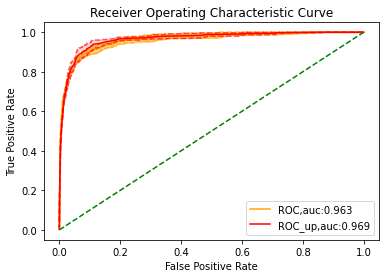

In [9]:
path = 'D:/CODE/KD/code_after_web/data/KeptGPT/without gender/k-fold/30' 
model_name = 'ensemble'
model_save_path = f'D:/CODE/KD/code_after_web/output/without gender/{model_name}'
if os.path.exists(model_save_path) == False:
    os.mkdir(model_save_path)
prc_curve_data = roc_plot_ensemble(path=path,random_state_1=30,color_origin='orange',color_up='red')